In [23]:
from scipy.stats import gamma, norm, poisson, multinomial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mpmath as mp
mp.dps = 100

This notebook contains code stubs and functions for you to fill out in order to complete Part 1 of HW3. Please copy and paste code from this document into your HW document as needed.

In [5]:
#Import dataset
coal_dat = pd.read_csv("coaldisasters-ds6040.csv")

0      4
1      5
2      4
3      1
4      0
      ..
107    0
108    0
109    1
110    0
111    1
Name: Count, Length: 112, dtype: int64

In [116]:
class CoalDisasterModel():
    def __init__(self, data, a_mu, b_mu, a_lambda, b_lambda, start_mu = 5, start_lambda = .1, start_k = 64, iter_num = 1000, burnin = 500):
        
        #Read in data and priors, and make them contained class variables
        self.data = data
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.a_lambda = a_lambda
        self.b_lambda = b_lambda
        self.iter_num = iter_num
        self.burnin = burnin
        #Initalize sampling containers
        self.mu = np.zeros(iter_num+burnin+1)
        self.lambdap = np.zeros(iter_num+burnin+1)
        self.k = np.zeros(iter_num+burnin+1)
        
        #Put in starting values
        self.mu[0] = start_mu
        self.lambdap[0] = start_lambda
        self.k[0] = start_k
        
        
        for i in np.arange(iter_num+burnin):
            if i % 100 == 0:
                print("Iteration " + str(i))
            
            
            #This is where you modify the sampler
            self.mu[i+1] = -1
            self.lambdap[i+1] = -1            
            
            #------------------This is the changepoint update block 
            likelihood_list = [] #Initialize an empty list
            
            # Iterate from 0 to 110 (the last timepoint cannot be the changepoint)
            for k_hat in range(111):
                #Probabilities get very small, so I am using the mp package to get arbitrarily fine grained precision. I am also computing the probabilities in log form, because
                #summing log probabilities is much easier (from a precision standpoint) than multiplying regular probabilities. This is likely overkill here
                temp = mp.mpf(np.sum(np.log(poisson.pmf(self.data['Count'][0:k_hat], self.mu[i+1])))+np.sum(np.log(poisson.pmf(self.data['Count'][(k_hat+1):111], self.lambdap[i+1]))))
                likelihood_list.append(temp)
            #Because my likelihoods are in log form, I need to transform them to be probabilities again.
            k_probs = [mp.exp(x) for x in likelihood_list]
            #Because floating point precision is the most frustrating thing, I convert everything float64
            k_probs = np.asarray(k_probs).astype('float64')
            
            #This normalizes the probabilities (so that they are probabilities)
            k_probs = k_probs/np.sum(k_probs)
            #Here is where I was tearing my hair out: Because of rounding errors, there is a chance that k_probs doesn't sum to 1 (mathematically it should)
            #now, the scipy multinomial function will error out if the probabilities sum to greater than 1, so I check the sum, and if greater than 1, I normalize again.
            if np.sum(k_probs)> 1.0:
                k_probs = k_probs/np.sum(k_probs)    
            #Finally, I sample from the multinomial, but because the multinomial.rvs returns an array, and I want an index, I use np.where to determine what index I sampled from.
            self.k[i+1] = np.where(multinomial.rvs(n=1, p = k_probs))[0]
            #------------------End changepoint block
            
    def plot_posteriors(self):
        f, axs = plt.subplots(3,2, figsize = (15, 7))
        f.tight_layout(pad = 3)
        sns.kdeplot(self.mu[self.burnin:],ax =axs[0,0])
        axs[0,0].set_xlabel(r'Posterior $\mu$')
        axs[0,0].set_ylabel('Probability Density')
        sns.kdeplot(self.lambdap[self.burnin:], ax =axs[1,0])
        axs[1,0].set_xlabel(r'Posterior $\lambda$')
        axs[1,0].set_ylabel('Probability Density')
        axs[2,0].hist(self.k[self.burnin:], bins = 112)
        axs[2,0].set_xlabel(r'Posterior k')
        axs[2,0].set_ylabel('Frequency')
        axs[0,1].plot(np.arange(self.iter_num+self.burnin+1),self.mu, '-')
        axs[0,1].set_xlabel('')
        axs[0,1].set_ylabel(r'Posterior $\mu$')
        axs[1,1].plot(np.arange(self.iter_num+self.burnin+1),self.lambdap,'-')
        axs[1,1].set_xlabel('')
        axs[1,1].set_ylabel(r'Posterior $\lambda$')
        axs[2,1].plot(np.arange(self.iter_num+self.burnin+1),self.k,'-')
        axs[2,1].set_xlabel('Iteration')
        axs[2,1].set_ylabel('Posterior k')
    
    def get_rate_estimates(self):
        to_return =pd.DataFrame(columns = ['Posterior EAP', 'Posterior Cred Interval Lower', 'Posterior Cred Interval Upper'])
        to_return.loc[r'mu', 'Posterior EAP'] = self.mu[self.burnin:].mean()
        to_return.loc[r'lambda', 'Posterior EAP'] = self.lambdap[self.burnin:].mean()
        to_return.loc[r'mu', 'Posterior Cred Interval Lower'] = np.quantile(self.mu[self.burnin:],.025)
        to_return.loc[r'lambda', 'Posterior Cred Interval Lower'] = np.quantile(self.lambdap[self.burnin:],.025)
        to_return.loc[r'mu', 'Posterior Cred Interval Upper'] = np.quantile(self.mu[self.burnin:],.975)
        to_return.loc[r'lambda', 'Posterior Cred Interval Upper'] = np.quantile(self.lambdap[self.burnin:],.975)
        return to_return
    
    def get_k_probs(self):
        freq = np.bincount(abs(self.k.astype('int'))[self.burnin:])
        ii = np.nonzero(freq)[0]
        freq = np.vstack((ii,freq[ii])).T
        freq = freq.astype("float16")
        freq[:,1] = freq[:,1]/(freq[:,1].sum())
        freq = pd.DataFrame(freq, columns=['k', 'Probability of k'])
        
        return freq

In [118]:
test = CoalDisasterModel(coal_dat, 1,1,1,1)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400


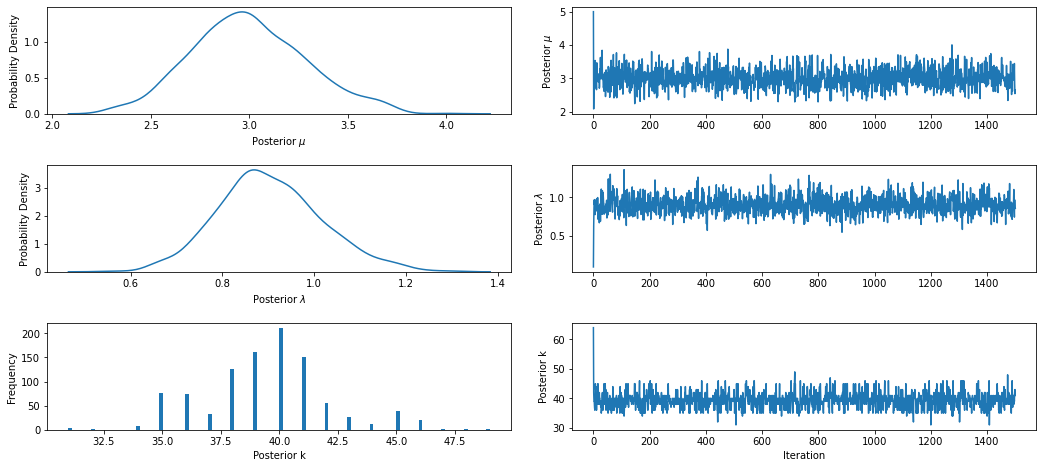

In [121]:
test.plot_posteriors()

,k,Probability of k
0,0.0,0.001999
1,1.0,0.004993
2,2.0,0.003998
3,3.0,0.009987
4,4.0,0.005993
5,5.0,0.015991
6,6.0,0.008987
7,7.0,0.002996
8,8.0,0.008987
9,9.0,0.008987


102